# Particle Flow Network to Handle Single Track Single Cluster Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
import scipy.constants as spc

import sys
sys.path.append('/home/russbate/MLPionCollaboration/LCStudies/')
from util import resolution_util as ru
from util import plot_util as pu
from util import deep_set_util as dsu

## Declare GPUS - import TensorFlow

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "4"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2021-08-03 09:42:40.613497: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-03 09:42:50.006891: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-03 09:42:50.030995: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-03 09:42:50.186715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-03 09:42:50.186767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-03 09:42:50.265653: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2

['/device:GPU:0']

so.10
2021-08-03 09:42:50.321108: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2021-08-03 09:42:50.340860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.11
2021-08-03 09:42:50.357305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.11
2021-08-03 09:42:50.361032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-08-03 09:42:50.365867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1888] Adding visible gpu devices: 0
2021-08-03 09:42:50.368650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-08-03 09:42:56.975661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1287] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-0

## Import EnergyFlow

In [4]:
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
print('Energy Flow Version: '+str(ef.__version__))

Energy Flow Version: 1.3.2


# Particle Truth Energy Target

### Load Data
#### X = [Energy, Eta, Phi, rPerp, Track Flag, Layer]
#### Y = [truthPartE, truthTrackPt, cluster_ENG_CALIB_TOT]

In [5]:
t0 = t.time()
Xraw = np.load('/data/rbate/X_STSC_502_files.npy', mmap_mode='r')[:175000,:,:]
Yraw = np.load('/data/rbate/Y_STSC_502_files.npy', mmap_mode='r')[:175000,:]

X = np.lib.format.open_memmap('/data/rbate/X_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/rbate/Y_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)
t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

Time to load memory mapped data: 21.938239574432373 (s)


In [6]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Number targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Number targets below 50 GeV: 0
Number of events: 175000


In [45]:
print(X.shape)

(175000, 1001, 5)


## Show Targets

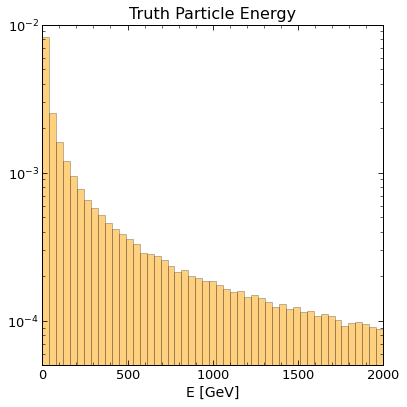

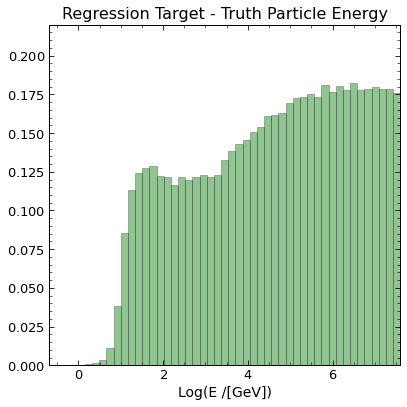

In [11]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,0][target_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Particle Energy', fontsize=16)
plt.xlabel('E [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_raw_2021-07-26.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Y, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Target - Truth Particle Energy', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/EnergyTargets_STSC_log_2021-07-26.png', format='png')
plt.show()

## Deep Set Normalization

In [12]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 55.886531591415405 (s)


## Show Inputs

<Figure size 799.992x599.976 with 0 Axes>

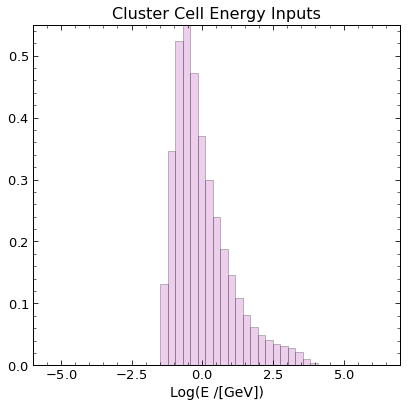

<Figure size 799.992x599.976 with 0 Axes>

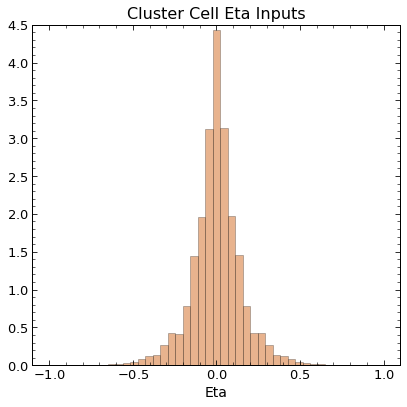

<Figure size 799.992x599.976 with 0 Axes>

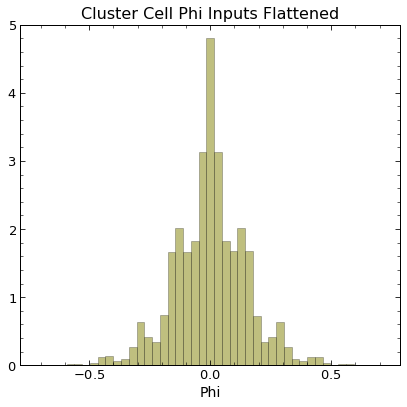

<Figure size 799.992x599.976 with 0 Axes>

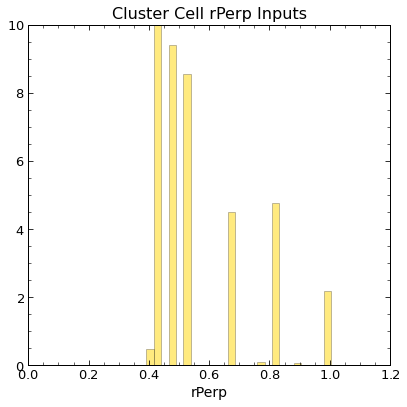

In [13]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STSC_E_2021-07-26.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STSC_Eta_2021-07-26.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-np.pi/4,np.pi/4,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STSC_Phi_2021-07-26.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/X_STSC_rPerp_2021-07-26.png', format='png')
plt.show()

### Model Settings

In [14]:
# EFN regression example uses 75/10/15 split for 100,000 samples
train, val, test = dsu.tvt_num(X, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 1500
batch_size = 3000

train -- val -- test
122500 -- 26250 -- 26250


#### Train/Val/Test Split

In [15]:
(x_train, x_val, x_test,
 y_train, y_val, y_test) = ef.utils.data_split(X, Y, val=val, test=test)

# Print out tensor shapes
print(np.shape(x_train))
print(np.shape(y_train))

(122500, 1001, 5)
(122500,)


### Build Particle Flow Network

In [16]:
netOpt = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt, metrics=[])

2021-07-26 15:26:36.114533: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-26 15:26:36.211606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-07-26 15:26:36.273873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-26 15:26:36.288684: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-26 15:26:36.290512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-26 15:26:36.293345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

## Train Model

In [17]:
t0 = t.time()
history = pfn.fit(x_train, y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        verbose=1)
t1 = t.time()

2021-07-26 15:27:42.358021: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2452450000 exceeds 10% of free system memory.
2021-07-26 15:27:45.649979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-26 15:27:45.691638: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Epoch 1/1500


2021-07-26 15:27:46.347685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-26 15:27:49.932018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


41/41 [==============================] - ETA: 0s - loss: 1597.7614

2021-07-26 15:28:03.849981: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 525525000 exceeds 10% of free system memory.


41/41 [==============================] - 19s 371ms/step - loss: 1573.2094 - val_loss: 24.4205
Epoch 2/1500
41/41 [==============================] - 10s 235ms/step - loss: 11.6886 - val_loss: 3.8738
Epoch 3/1500
41/41 [==============================] - 9s 210ms/step - loss: 3.3726 - val_loss: 2.1338
Epoch 4/1500
41/41 [==============================] - 8s 200ms/step - loss: 2.0357 - val_loss: 1.4539
Epoch 5/1500
41/41 [==============================] - 8s 191ms/step - loss: 1.3648 - val_loss: 0.9972
Epoch 6/1500
41/41 [==============================] - 8s 201ms/step - loss: 0.9252 - val_loss: 0.6500
Epoch 7/1500
41/41 [==============================] - 8s 186ms/step - loss: 0.6146 - val_loss: 0.4970
Epoch 8/1500
41/41 [==============================] - 8s 185ms/step - loss: 0.5360 - val_loss: 0.3892
Epoch 9/1500
41/41 [==============================] - 9s 209ms/step - loss: 0.4021 - val_loss: 0.3262
Epoch 10/1500
41/41 [==============================] - 8s 189ms/step - loss: 0.3484 - va

In [18]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 11345.878733158112 (s)
189.09797888596853 (min)
3.1516329814328086 (hour)


### Loss Curves

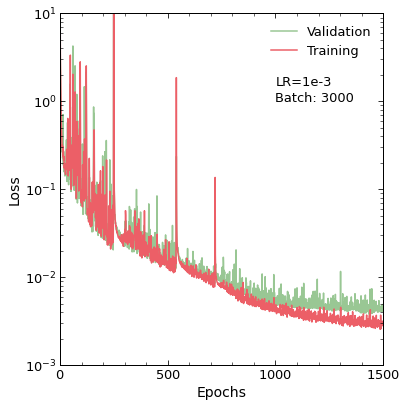

In [20]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/STSC_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Predictions

In [21]:
preds = np.exp(pfn.predict(x_test, batch_size=3000).flatten())
print(preds.shape)

2021-07-26 20:00:33.499119: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 525525000 exceeds 10% of free system memory.


(26250,)


#### Histogram of Predictions

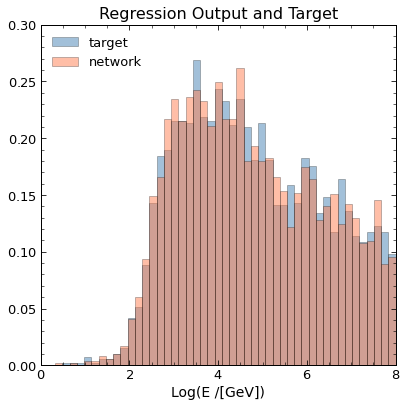

In [22]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(y_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/STSC_targetPreds_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Analytics
#### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

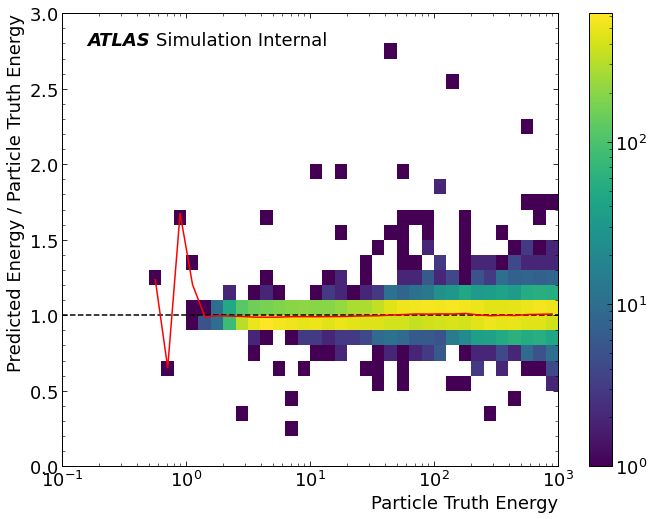

In [31]:
resplot = ru.responsePlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/July/STSC_responsePlot_3000batch_LR1e-3_2021-07-26.png

#### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

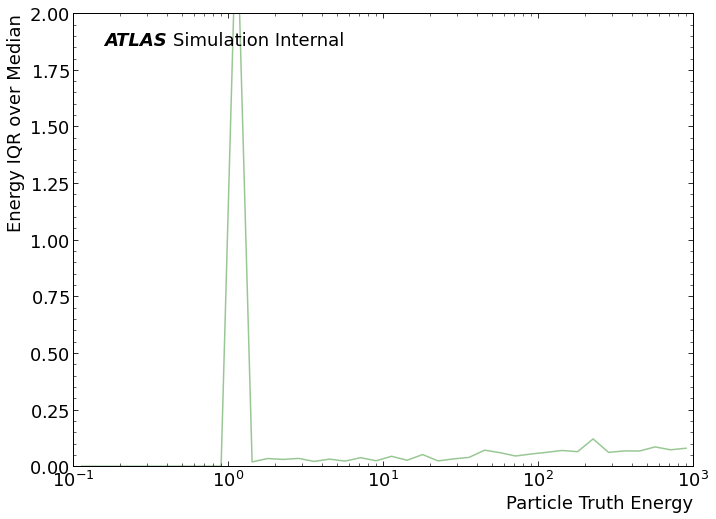

In [33]:
resp_plot = ru.resolutionPlot(x=np.exp(y_test), y=preds/np.exp(y_test),
                    figfile='',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/July/STSC_resolutionPlot_3000batch_LR1e-3_2021-07-26.png

# Track Only Targets

In [34]:
# the target energy values
track_zero_mask = Yraw[:,1] > .05
Ytr = np.log(Yraw[track_zero_mask,1])
print('Number targets below 50 GeV: '+str(np.count_nonzero(np.invert(track_zero_mask))))
print('Number of events: '+str(len(Ytr)))

Number targets below 50 GeV: 0
Number of events: 175000


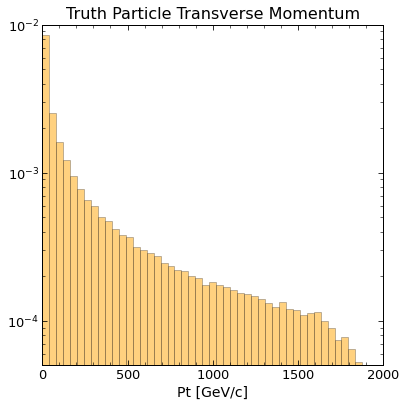

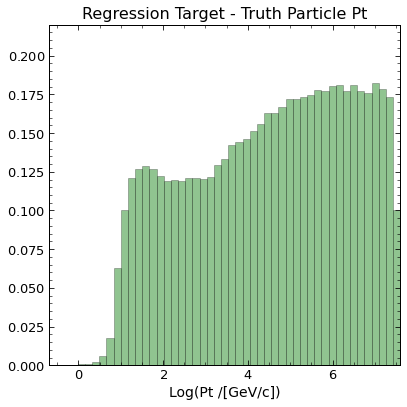

In [36]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,1][track_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Particle Transverse Momentum', fontsize=16)
plt.xlabel('Pt [GeV/c]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/MomentumTargets_STSC_raw_2021-07-26.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.5), np.log(2000), 50, endpoint=True)
plt.hist(Ytr, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Target - Truth Particle Pt', fontsize=16)
plt.xlabel('Log(Pt /[GeV/c])', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/MomentumTargets_STSC_log_2021-07-26.png', format='png')
plt.show()

### Select Track Only Data

In [55]:
istrack = np.zeros(X.shape[0], dtype=np.bool_)
Xtr = np.zeros((X.shape[0], 6, 4))
for j in range(X.shape[0]):
    trackflag = X[j,:,4] == 1
    nTrckPts = np.count_nonzero(trackflag)
    Xtr[j,:nTrckPts,:4] = X[j,trackflag,:4]
    if nTrckPts > 0:
        istrack[j] = 1
print('Number of events with tracks: '+str(np.count_nonzero(istrack)))
print(Xtr.shape)

Number of events with tracks: 175000
(175000, 6, 4)


### Model Parameters

In [56]:
(xtr_train, xtr_val, xtr_test,
 ytr_train, ytr_val, ytr_test) = ef.utils.data_split(Xtr, Ytr, val=val, test=test)

# Print out tensor shapes
print(np.shape(xtr_train))
print(np.shape(ytr_train))

(122500, 6, 4)
(122500,)


### Build PFN

In [61]:
netOptTr = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfnTr = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOptTr, metrics=[])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

### Train Network

In [62]:
t0 = t.time()
historyTr = pfnTr.fit(xtr_train, ytr_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(xtr_val, ytr_val),
        verbose=1)
t1 = t.time()

Epoch 1/1500
41/41 [==============================] - 1s 10ms/step - loss: 30.3830 - val_loss: 0.2690
Epoch 2/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.1700 - val_loss: 0.0979
Epoch 3/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0905 - val_loss: 0.0841
Epoch 4/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0768 - val_loss: 0.0771
Epoch 5/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0707 - val_loss: 0.0685
Epoch 6/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0646 - val_loss: 0.0649
Epoch 7/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0608 - val_loss: 0.0599
Epoch 8/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0554 - val_loss: 0.0564
Epoch 9/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0552 - val_loss: 0.0590
Epoch 10/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.05

In [63]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 308.68583726882935 (s)
5.1447639544804895 (min)
0.08574606590800815 (hour)


### Loss Curves

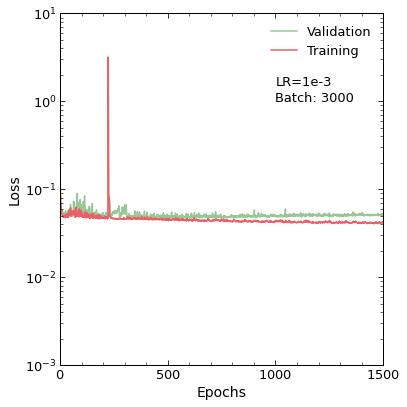

In [127]:
fig = plt.figure(figsize=(6,6))
plt.plot(historyTr.history['val_loss'], label="Validation")
plt.plot(historyTr.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/Pt_lossCurves_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Predictions

In [66]:
predsTr = np.exp(pfnTr.predict(xtr_test, batch_size=3000).flatten())
print(preds.shape)

(26250,)


#### Histogram of Predictions

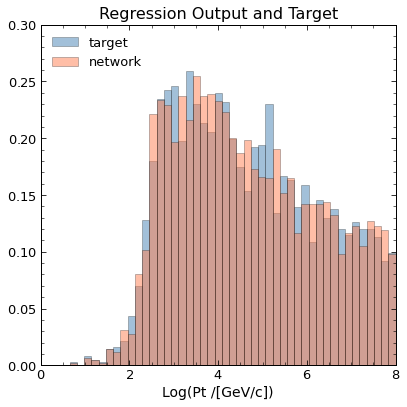

In [126]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(ytr_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(predsTr, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(Pt /[GeV/c])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/Pt_targetPreds_3000batch_LR1e-3_2021-07-26.png', format='png')
plt.show()

### Analytics
#### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

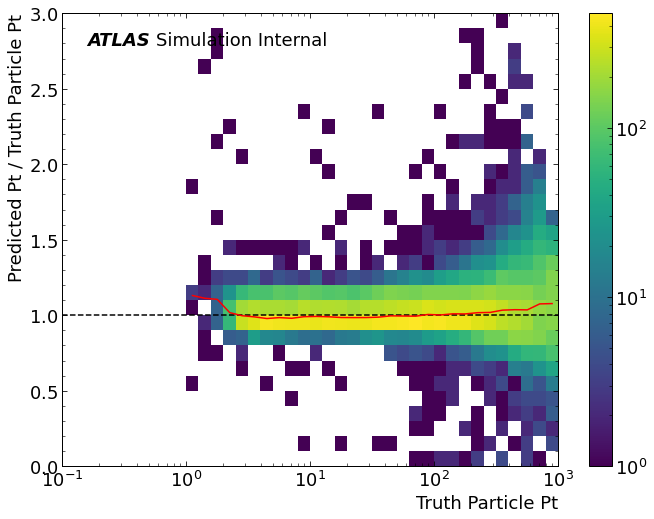

In [117]:
resplot = ru.responsePlot(x=np.exp(ytr_test), y=predsTr/np.exp(ytr_test),
                figfile='Regression_Plots/July/trackPt_responsePlot_3000batch_LR1e-3_2021-07-26.png',
                statistic='median', xlabel='Truth Particle Pt', ylabel='Predicted Pt / Truth Particle Pt',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/July/trackPt_responsePlot_3000batch_LR1e-3_2021-07-26.png

#### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

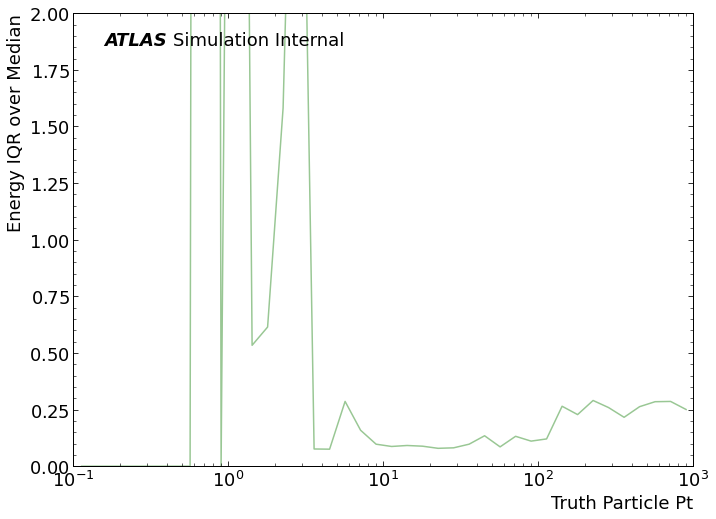

In [116]:
resolplot = ru.resolutionPlot(x=np.exp(ytr_test), y=predsTr/np.exp(ytr_test),
                    figfile='Regression_Plots/July/trackPt_resolutionPlot_3000batch_LR1e-3_2021-07-26.png',
                    statistic='std', xlabel='Truth Particle Pt', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/July/trackPt_resolutionPlot_3000batch_LR1e-3_2021-07-26.png

# Cluster Only Targets

In [86]:
# the target energy values
clust_zero_mask = Yraw[:,2] > 0
Ycl = np.log(Yraw[clust_zero_mask,2])
print('Number targets below 50 GeV: '+str(np.count_nonzero(np.invert(clust_zero_mask))))
print('Number of events: '+str(len(Ycl)))

Number targets below 50 GeV: 19
Number of events: 174981


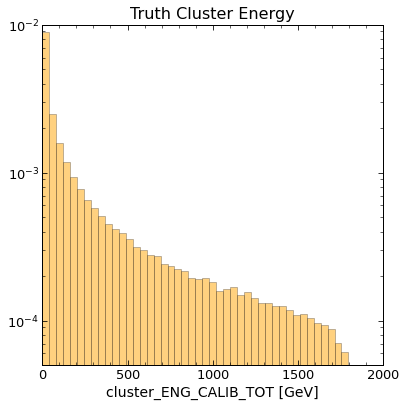

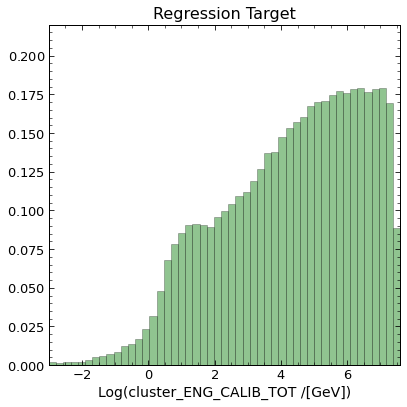

In [118]:
## RAW DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(0,2000,50,endpoint=True)
plt.hist(Yraw[:,2][clust_zero_mask], color='orange', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='raw regression target')
plt.title('Truth Cluster Energy', fontsize=16)
plt.xlabel('cluster_ENG_CALIB_TOT [GeV]', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.yscale('log')
plt.ylim(.00005,.01)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/ClusterTargets_STSC_raw_2021-07-26.png', format='png')
plt.show()

## NORMALIZED DATA ##
#=================================================================
fig = plt.figure(figsize=(6,6))
bins=np.linspace(np.log(.05), np.log(2000), 50, endpoint=True)
plt.hist(Ycl, color='forestgreen', bins=bins, density=True, alpha=.5, edgecolor='black',
        label='log')
plt.title('Regression Target', fontsize=16)
plt.xlabel('Log(cluster_ENG_CALIB_TOT /[GeV])', fontsize=14)
plt.xlim(np.min(bins),np.max(bins))
plt.ylim(0,.22)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/ClusterTargets_STSC_log_2021-07-26.png', format='png')
plt.show()

### Select Cluster Only Data

In [88]:
# we know (because we made the data :-) ) that the clusters are placed first
Xcl = np.zeros((Ycl.shape[0], X.shape[1]-6, 4))
clust_indices = np.arange(X.shape[0])[clust_zero_mask]
for i in range(Ycl.shape[0]):
    j = clust_indices[i]
    trackflag = X[j,:,4] == 1
    trckIdx0 = np.argmax(trackflag)
    Xcl[i,:trckIdx0,:4] = X[j,:trckIdx0,:4]

print(X.shape)
print(Xcl.shape)

(175000, 1001, 5)
(174981, 995, 4)


### Model Parameters

In [89]:
print(Xcl.shape)
print(Ycl.shape)

(174981, 995, 4)
(174981,)


In [91]:
train, val, test = dsu.tvt_num(Xcl, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

(xcl_train, xcl_val, xcl_test,
 ycl_train, ycl_val, ycl_test) = ef.utils.data_split(Xcl, Ycl, val=val, test=test)

# Print out tensor shapes
print(np.shape(xcl_train))
print(np.shape(ycl_train))

train -- val -- test
122487 -- 26247 -- 26247
(122487, 995, 4)
(122487,)


### Build PFN Cluster

In [112]:
netOptCl = tf.keras.optimizers.Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfnCl = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOptTr, metrics=[])

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
____________________________________________________________________________________________

In [ ]:
t0 = t.time()
historyCl = pfnCl.fit(xcl_train, ycl_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(xcl_val, ycl_val),
        verbose=1)
t1 = t.time()

Epoch 1/1500
41/41 [==============================] - 14s 326ms/step - loss: 14372.3559 - val_loss: 12.3622
Epoch 2/1500
41/41 [==============================] - 7s 177ms/step - loss: 12.8546 - val_loss: 4.7017
Epoch 3/1500
41/41 [==============================] - 7s 178ms/step - loss: 4.3613 - val_loss: 3.9076
Epoch 4/1500
41/41 [==============================] - 7s 180ms/step - loss: 3.6890 - val_loss: 3.3839
Epoch 5/1500
41/41 [==============================] - 7s 179ms/step - loss: 3.1718 - val_loss: 2.8100
Epoch 6/1500
41/41 [==============================] - 7s 179ms/step - loss: 2.6463 - val_loss: 2.3984
Epoch 7/1500
41/41 [==============================] - 7s 178ms/step - loss: 2.3063 - val_loss: 2.2029
Epoch 8/1500
41/41 [==============================] - 7s 180ms/step - loss: 2.0315 - val_loss: 1.9132
Epoch 9/1500
41/41 [==============================] - 7s 181ms/step - loss: 1.8591 - val_loss: 1.7559
Epoch 10/1500
41/41 [==============================] - 7s 179ms/step - loss

### Loss Curves

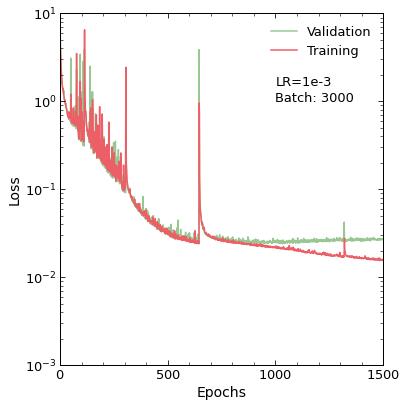

In [125]:
fig = plt.figure(figsize=(6,6))
plt.plot(historyCl.history['val_loss'], label="Validation")
plt.plot(historyCl.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,1500)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/cluster_lossCurves_3000batch_LR1e-3_2021-07-27.png', format='png')
plt.show()

### Predictions

In [120]:
predsCl = np.exp(pfnCl.predict(xcl_test, batch_size=3000).flatten())
print(preds.shape)

(26250,)


#### Histogram of Predictions

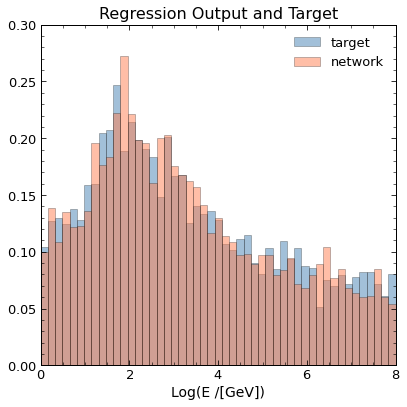

In [121]:
## PREDICTIONS AND TRUTH ##
bins=np.linspace(0, 8, 50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(ycl_test), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(predsCl, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(np.min(bins),8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/cluster_targetPreds_3000batch_LR1e-3_2021-07-27.png', format='png')
plt.show()

## Analytics
### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

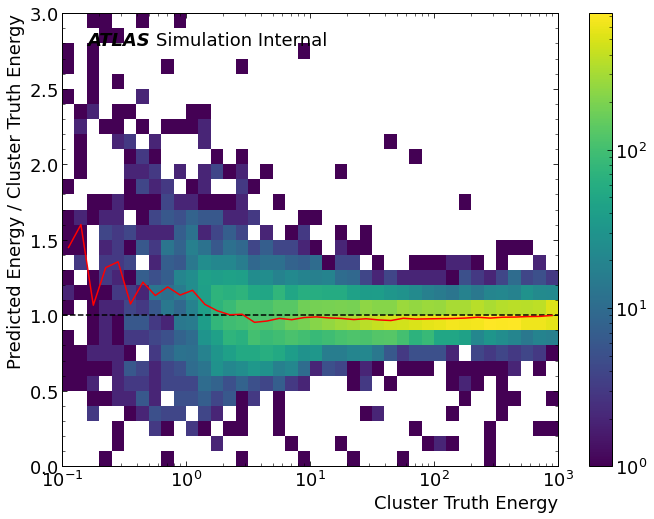

In [123]:
resplot = ru.responsePlot(x=np.exp(ycl_test), y=predsCl/np.exp(ycl_test),
                figfile='Regression_Plots/July/cluster_responsePlot_3000batch_LR1e-3_2021-07-27.png',
                statistic='median', xlabel='Cluster Truth Energy', ylabel='Predicted Energy / Cluster Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/July/cluster_responsePlot_3000batch_LR1e-3_2021-07-27.png

### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

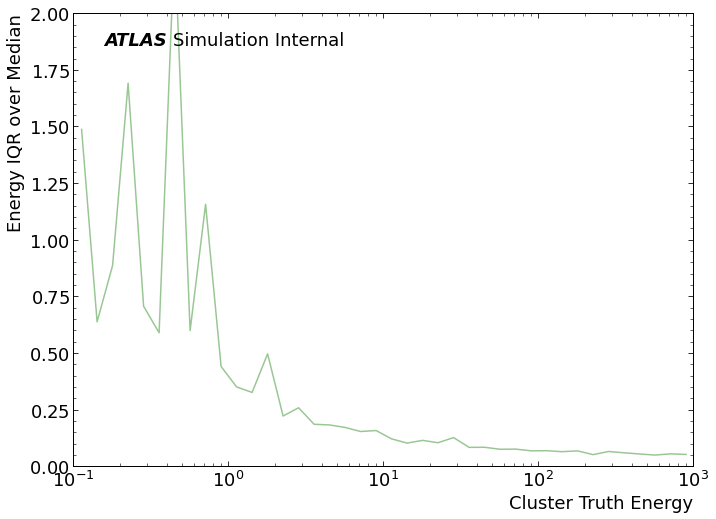

In [124]:
resolplot = ru.resolutionPlot(x=np.exp(ycl_test), y=predsCl/np.exp(ycl_test),
                    figfile='Regression_Plots/July/cluster_resolutionPlot_3000batch_LR1e-3_2021-07-27.png',
                    statistic='std', xlabel='Cluster Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/July/cluster_resolutionPlot_3000batch_LR1e-3_2021-07-27.png

# Experimenting with tf Dataset

### Load Data

In [26]:
t0 = t.time()
Xraw = np.load('/data/rbate/X_STSC_502_files.npy', mmap_mode='r')
Yraw = np.load('/data/rbate/Y_STSC_502_files.npy', mmap_mode='r')

X = np.lib.format.open_memmap('/data/rbate/X_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 5))
np.copyto(dst=X, src=Xraw[:,:,:5], casting='same_kind', where=True)

Y = np.lib.format.open_memmap('/data/rbate/Y_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Yraw.shape[0]))
np.copyto(dst=Y, src=Yraw[:,0], casting='same_kind', where=True)
t1 = t.time()
print('Time to load memory mapped data: '+str(t1-t0)+' (s)')

Time to load memory mapped data: 134.64041924476624 (s)


In [27]:
# the target energy values
target_zero_mask = Yraw[:,0] > .05
Y = np.log(Yraw[target_zero_mask,0])
print('Number targets below 50 GeV: '+str(np.count_nonzero(np.invert(target_zero_mask))))
print('Number of events: '+str(len(Y)))

Number targets below 50 GeV: 0
Number of events: 1011970


## Normalization

In [28]:
t0 = t.time()
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std
t1 = t.time()
print('Time to Normalize: '+str(t1-t0)+' (s)')

Time to Normalize: 47.635781049728394 (s)


In [81]:
deepSets = tf.data.Dataset.from_tensor_slices((X, Y))

In [82]:
train, val, test = dsu.tvt_num(deepSets, tvt=(70, 15, 15))
print('train -- val -- test')
print(str(train)+' -- '+str(val)+' -- '+str(test))

train -- val -- test
708379 -- 151796 -- 151795


In [83]:
ds_train = deepSets.skip(val+test)
ds_test = deepSets.take(test+val)
ds_val = ds_test.skip(test)
ds_test = ds_test.take(test)
print(ds_train.cardinality())
print(ds_val.cardinality())
print(ds_test.cardinality())

tf.Tensor(708379, shape=(), dtype=int64)
tf.Tensor(151796, shape=(), dtype=int64)
tf.Tensor(151795, shape=(), dtype=int64)


#### Determine Number of Batches
Pass this number to the dataset object

In [84]:
batch_size = 3000

Nevts = len(Y)
Nbatches = int(np.floor(Nevts/3000))
print(Nbatches)

337


In [85]:
ds_train = ds_train.batch(Nbatches, drop_remainder=True)
ds_val = ds_val.batch(Nbatches, drop_remainder=True)
ds_test = ds_test.batch(Nbatches, drop_remainder=True)

#### Model Params

In [86]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

### Build Robot

In [106]:
netOpt2 = tf.keras.optimizers.Adam(
    learning_rate=.003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

pfn2 = PFN(input_dim=5, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss,
          optimizer=netOpt2, metrics=[])

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_42 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_42[0][0]              
____________________________________________________________________________________________

### Train Robot, good Robot :)

In [107]:
t0 = t.time()
history2 = pfn2.fit(ds_train,
        epochs=100,
        validation_data=ds_val,
        verbose=1)
t1 = t.time()

Epoch 1/100
2102/2102 [==============================] - 160s 75ms/step - loss: 440.4185 - val_loss: 0.5852
Epoch 2/100
2102/2102 [==============================] - 131s 60ms/step - loss: 0.3178 - val_loss: 0.0805
Epoch 3/100
2102/2102 [==============================] - 136s 64ms/step - loss: 0.1837 - val_loss: 0.0374
Epoch 4/100
2102/2102 [==============================] - 130s 60ms/step - loss: 0.0721 - val_loss: 0.0290
Epoch 5/100
2102/2102 [==============================] - 127s 60ms/step - loss: 2.3859 - val_loss: 0.0360
Epoch 6/100
2102/2102 [==============================] - 132s 62ms/step - loss: 0.0388 - val_loss: 0.0462
Epoch 7/100
2102/2102 [==============================] - 126s 59ms/step - loss: 0.0419 - val_loss: 0.1068
Epoch 8/100
2102/2102 [==============================] - 128s 60ms/step - loss: 0.0303 - val_loss: 0.0278
Epoch 9/100
2102/2102 [==============================] - 127s 59ms/step - loss: 0.0242 - val_loss: 0.0199
Epoch 10/100
2102/2102 [====================

In [108]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 15951.492631435394 (s)
265.8582105239232 (min)
4.430970175398721 (hour)


### Loss Curves

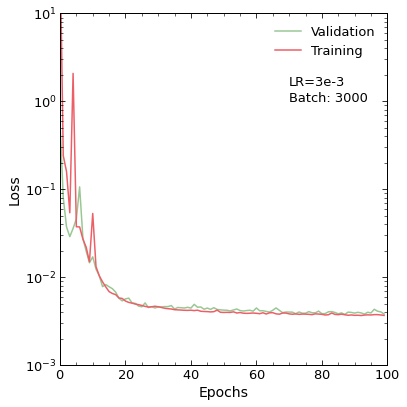

In [110]:
M = len(history2.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history2.history['val_loss'], label="Validation")
plt.plot(history2.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
plt.text(.7*M, 1.5, 'LR=3e-3', fontsize=13)
plt.text(.7*M, 1, 'Batch: 3000', fontsize=13)
plt.tight_layout()
plt.savefig('Regression_Plots/August/LD_STSC_lossCurves_3000batch_LR3e-3_2021-08-04.png', format='png')
plt.show()

## Predictions

In [55]:
import tensorflow_datasets as tfds

In [97]:
t0 = t.time()
preds2 = np.exp(pfn2.predict(ds_test).flatten())
print(preds2.shape)
t1 = t.time()
print('Time to make predictions: '+str(t1-t0)+' (s)')

(151650,)
Time to make predictions: 62.41769075393677 (s)


In [98]:
ds_test = ds_test.unbatch()
Npts = len(ds_test)
print(Npts)
Ytest = np.empty(Npts)

151650


In [99]:
i = 0
for element in ds_test:
    Xi, Yi = element
    Ytest[i] = Yi
    i += 1

### Histogram of Predictions

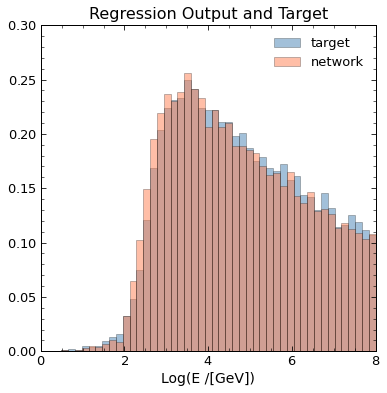

In [100]:
## PREDICTIONS AND TRUTH ##
bins=np.linspace(0, 8, 50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(Ytest), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds2, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E /[GeV])', fontsize=14)
plt.xlim(np.min(bins),8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right')
# plt.tight_layout()
# plt.savefig('Regression_Plots/August/LD_targetPreds_3000batch_LR1e-3_2021-08-04.png', format='png')
plt.show()

## Analytics
#### Response Plot

<Figure size 799.992x599.976 with 0 Axes>

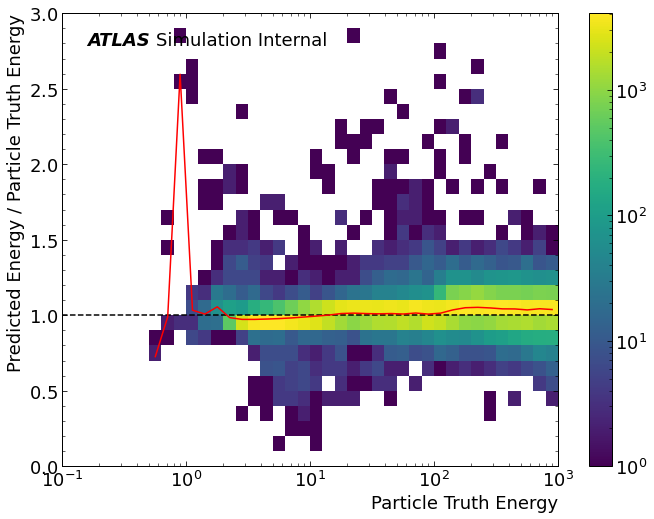

In [103]:
resplot2 = ru.responsePlot(x=np.exp(Ytest), y=preds2/np.exp(Ytest),
                figfile='',
                statistic='median', xlabel='Particle Truth Energy', ylabel='Predicted Energy / Particle Truth Energy',
                atlas_x=.05, atlas_y=.96, simulation=True, cblabel='',
                textlist=[])
# Regression_Plots/August/LD_STSC_responsePlot_3000batch_LR5e-3_2021-08-04.png

#### Resolution Plot

<Figure size 799.992x599.976 with 0 Axes>

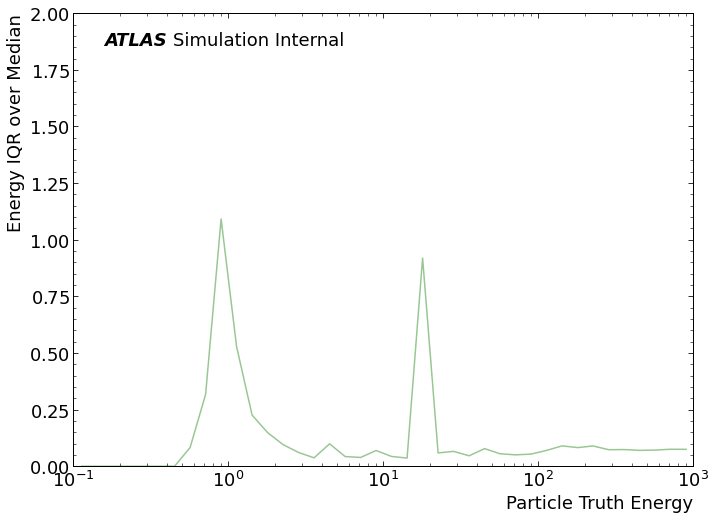

In [105]:
resolplot2 = ru.resolutionPlot(x=np.exp(Ytest), y=preds2/np.exp(Ytest),
                    figfile='',
                    statistic='std', xlabel='Particle Truth Energy', ylabel='Energy IQR over Median',
                    atlas_x=.05, atlas_y=.96, simulation=True,
                    textlist=[])
# Regression_Plots/August/LD_STSC_resolutionPlot_3000batch_LR5e-3_2021-08-04.png